# Mamba Causal Tracing Visualization

This notebook demonstrates causal tracing on Mamba State Space Models and visualizes the results as heatmaps (similar to the ROME paper).

The heatmap shows which (layer, position) pairs are critical for factual recall:
- **X-axis**: Token positions in the prompt
- **Y-axis**: Model layers (0 = earliest, higher = later)
- **Color**: Probability of correct answer when that state is restored
  - Blue/Dark: Low probability (restoration doesn't help)
  - Yellow/Bright: High probability (restoration recovers the answer)

In [22]:
# Imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from mamba_causal_analysis.mamba_models import load_mamba_model
from mamba_causal_analysis.mamba_causal_trace import calculate_hidden_flow

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful
PyTorch version: 2.4.1+cu121
CUDA available: True


## 1. Load Mamba Model

In [23]:
# Load Mamba-130m (smallest model for quick experimentation)
model_name = "state-spaces/mamba-130m"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading {model_name}...")
mt = load_mamba_model(model_name, device=device)
print(f"✓ Model loaded with {mt.num_layers} layers")
print(f"  Device: {mt.device}")

Loading state-spaces/mamba-130m...
Loading Mamba model: state-spaces/mamba-130m


/Users/ajbailey4@ad.wisc.edu/mamba-causal-analysis/.venv/lib/python3.10/site-packages/mamba_ssm/utils/hf.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.lo

Identified 24 Mamba layers
✓ Model loaded with 24 layers
  Device: cuda


## 2. Define Test Prompt

Choose a factual prompt where we know the answer. We'll trace which parts of the model are responsible for recalling this fact.

In [24]:
# Example factual prompts (choose one or add your own)
test_cases = [
    {"prompt": "The Eiffel Tower is located in", "subject": "Eiffel Tower"},
    {"prompt": "The Space Needle is located in downtown", "subject": "Space Needle"},
    {"prompt": "The mother tongue of Angela Merkel is", "subject": "Angela Merkel"},
    {"prompt": "Apple Inc. was founded by Steve", "subject": "Apple Inc"},
]

# Select test case
test = test_cases[0]  # Change index to try different prompts
prompt = test["prompt"]
subject = test["subject"]

print(f"Prompt: \"{prompt}\"")
print(f"Subject: \"{subject}\"")
print()

# Test what the model predicts
tokens = mt.tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = mt.model(tokens["input_ids"])
    if hasattr(outputs, 'logits'):
        logits = outputs.logits
    else:
        logits = outputs
    
    probs = torch.softmax(logits[0, -1, :], dim=0)
    top_tokens = torch.topk(probs, 5)
    
print("Model's top 5 predictions:")
for prob, token_id in zip(top_tokens.values, top_tokens.indices):
    token_str = mt.tokenizer.decode([token_id.item()])
    print(f"  {token_str:20s} {prob.item():.4f}")

Prompt: "The Eiffel Tower is located in"
Subject: "Eiffel Tower"

Model's top 5 predictions:
   Paris               0.5299
   the                 0.2801
   France              0.0180
   New                 0.0158
   Vers                0.0094


## 3. Run Causal Tracing

This cell will:
1. Run the clean input and save all hidden states
2. For each (layer, position) pair:
   - Corrupt the input with noise
   - Restore the clean state at that location
   - Measure how much this helps recover the correct answer
3. Return a matrix of scores for visualization

**Note**: This takes a few minutes (tracing all layer × position combinations).

In [25]:
# Run causal tracing - ALL THREE MODES
samples = 10  # Number of noise samples (10 for testing, 100 for publication)
noise_level = 3.0  # Standard deviations of noise (ROME standard)

print("="*60)
print("CAUSAL TRACING: THREE MODES COMPARISON")
print("="*60)
print(f"Subject tokens will be corrupted: '{subject}'")
print(f"All other tokens remain clean")
print()

# Mode 1: Per-layer (fastest)
print("Mode 1: Per-Layer (restoring residual stream)")
print(f"  Tracing {mt.num_layers} layers")
print(f"  Estimated time: ~{mt.num_layers * samples * 0.1:.1f} seconds")

result_per_layer = calculate_hidden_flow(
    mt,
    mt.tokenizer,
    prompt=prompt,
    subject=subject,
    samples=samples,
    noise_level=noise_level,
    mode="per_layer",
)

print(f"  ✓ Complete!")
print(f"    Clean: {result_per_layer['high_score']:.4f}")
print(f"    Corrupted: {result_per_layer['low_score']:.4f}")
print()

# Mode 2: Per-position hidden states (medium speed)
print("Mode 2: Per-Position Hidden States")
print(f"  Tracing {mt.num_layers} layers × {len(result_per_layer['input_tokens'])} positions")
print(f"  Using reduced samples=3 for speed")

result_per_position = calculate_hidden_flow(
    mt,
    mt.tokenizer,
    prompt=prompt,
    subject=subject,
    samples=3,  # Reduced for speed
    noise_level=noise_level,
    mode="per_position",
)

print(f"  ✓ Complete!")
print(f"    Clean: {result_per_position['high_score']:.4f}")
print(f"    Corrupted: {result_per_position['low_score']:.4f}")
print()

# Mode 3: Per-position SSM states (slowest - optional)
print("Mode 3: Per-Position SSM States (SLOW - token-by-token)")
print(f"  This will take 15-30 minutes with samples=3")
print(f"  Set RUN_SSM_MODE = True to enable")

RUN_SSM_MODE = True  # Change to True to run SSM state tracing

if RUN_SSM_MODE:
    result_per_position_ssm = calculate_hidden_flow(
        mt,
        mt.tokenizer,
        prompt=prompt,
        subject=subject,
        samples=3,
        noise_level=noise_level,
        mode="per_position_ssm",
    )
    print(f"  ✓ Complete!")
    print(f"    Clean: {result_per_position_ssm['high_score']:.4f}")
    print(f"    Corrupted: {result_per_position_ssm['low_score']:.4f}")
else:
    print(f"  (Skipped - set RUN_SSM_MODE = True to enable)")
    result_per_position_ssm = None

print()
print("="*60)

CAUSAL TRACING: THREE MODES COMPARISON
Subject tokens will be corrupted: 'Eiffel Tower'
All other tokens remain clean

Mode 1: Per-Layer (restoring residual stream)
  Tracing 24 layers
  Estimated time: ~24.0 seconds
Tracing 24 layers (per-layer mode)...
  Completed layer 5/24
  Completed layer 10/24
  Completed layer 15/24
  Completed layer 20/24
  ✓ Complete!
    Clean: 0.5299
    Corrupted: 0.0028

Mode 2: Per-Position Hidden States
  Tracing 24 layers × 8 positions
  Using reduced samples=3 for speed
Tracing 24 layers (per-layer mode)...
  Completed layer 5/24
  Completed layer 10/24
  Completed layer 15/24
  Completed layer 20/24
  ✓ Complete!
    Clean: 0.5299
    Corrupted: 0.0007

Mode 3: Per-Position SSM States (SLOW - token-by-token)
  This will take 15-30 minutes with samples=3
  Set RUN_SSM_MODE = True to enable
Tracing 24 layers x 8 positions (per-position SSM state mode)...
  Completed layer 5/24
  Completed layer 10/24
  Completed layer 15/24
  Completed layer 20/24
  ✓ 

## 4. Visualize Results

For **per-layer mode**, we plot layer importance as a line graph.
For **per-position mode**, we would show a 2D heatmap.

**Note about Mamba vs Transformers:**
- In transformers, late layers can be restored independently because attention is parallel
- In Mamba, the residual stream flows forward through layers, making early layers very important
- Restoring layer 0 cleans the entire residual stream for all subsequent layers!


Most important restoration:
  Layer 19, Position 4
  Token: ' Tower'
  Score: 0.0362


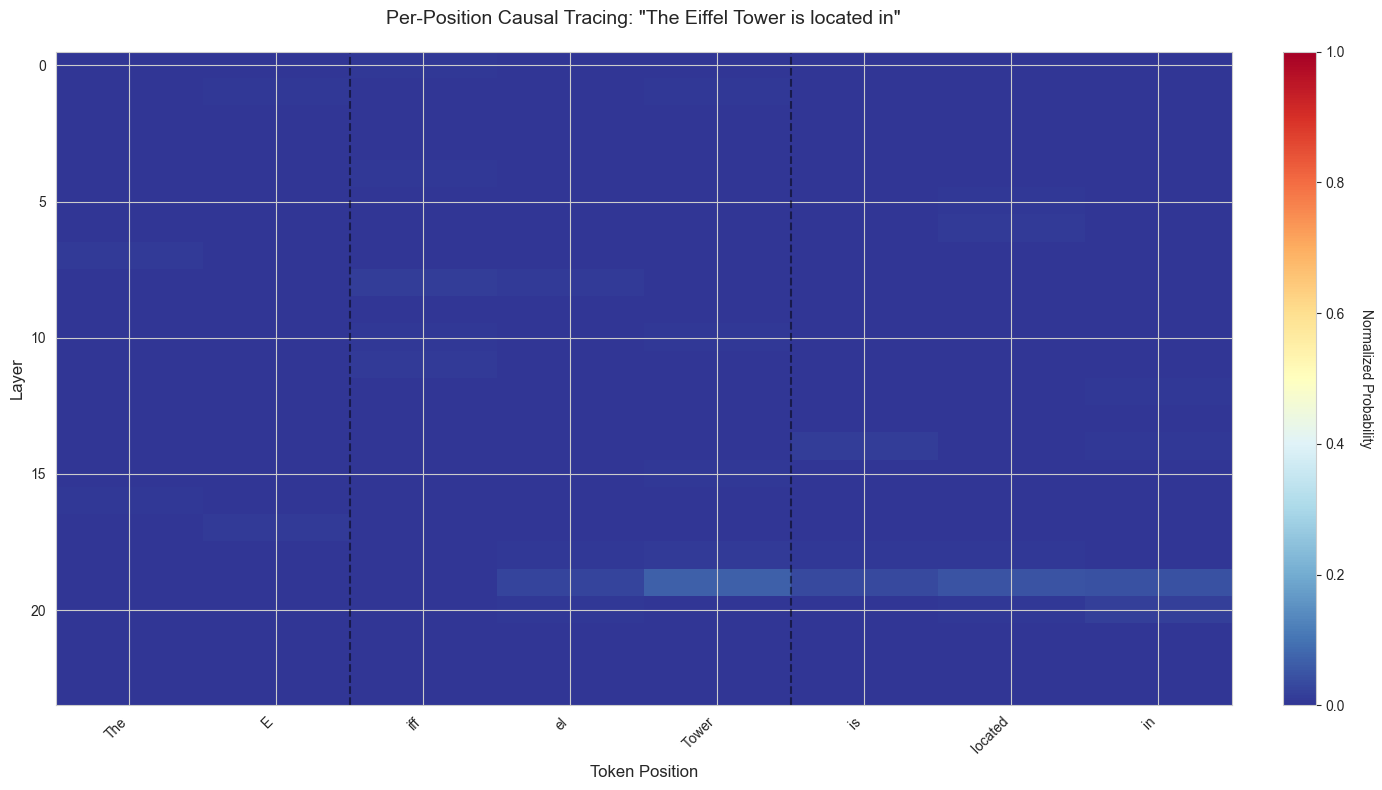

In [27]:
def plot_layer_importance(result, title=None):
    """
    Plot per-layer causal tracing results.
    """
    scores = result['scores']
    low_score = result['low_score']
    high_score = result['high_score']
    
    # Check if this is per-layer (1D) or per-position (2D)
    if scores.ndim == 1:
        # Per-layer mode
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ax.plot(scores, marker='o', linewidth=2, markersize=8, label='Layer restoration effect')
        ax.axhline(y=low_score, color='r', linestyle='--', label='Corrupted baseline', alpha=0.7, linewidth=2)
        ax.axhline(y=high_score, color='g', linestyle='--', label='Clean baseline', alpha=0.7, linewidth=2)
        
        ax.set_xlabel('Layer', fontsize=12)
        ax.set_ylabel('Probability of Correct Answer', fontsize=12)
        
        if title is None:
            title = f'Per-Layer Causal Tracing: "{result.get("prompt", "")}"'
        ax.set_title(title, fontsize=14, pad=20)
        
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Find most important layer
        max_layer = scores.argmax()
        print(f"\nMost important layer: {max_layer}")
        print(f"  Score: {scores[max_layer]:.4f}")
        
    else:
        # Per-position mode (2D heatmap)
        tokens = result['input_tokens']
        subj_start, subj_end = result['subject_range']
        
        # Normalize scores
        normalized_scores = (scores - low_score) / (high_score - low_score)
        normalized_scores = np.clip(normalized_scores, 0, 1)
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        im = ax.imshow(
            normalized_scores,
            aspect='auto',
            cmap='RdYlBu_r',
            vmin=0,
            vmax=1,
            interpolation='nearest'
        )
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Normalized Probability', rotation=270, labelpad=20)
        
        ax.set_xlabel('Token Position', fontsize=12)
        ax.set_ylabel('Layer', fontsize=12)
        ax.set_xticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=45, ha='right')
        
        # Highlight subject
        ax.axvline(subj_start - 0.5, color='black', linestyle='--', alpha=0.5)
        ax.axvline(subj_end + 0.5, color='black', linestyle='--', alpha=0.5)
        
        if title is None:
            title = f'Per-Position Causal Tracing: "{result.get("prompt", "")}"'
        ax.set_title(title, fontsize=14, pad=20)
        
        plt.tight_layout()
        
        # Find most important position
        max_layer, max_pos = np.unravel_index(scores.argmax(), scores.shape)
        print(f"\nMost important restoration:")
        print(f"  Layer {max_layer}, Position {max_pos}")
        print(f"  Token: '{tokens[max_pos]}'")
        print(f"  Score: {scores[max_layer, max_pos]:.4f}")
    
    return fig

# Plot the results
fig = plot_layer_importance(result_per_position_ssm)
plt.show()

TypeError: Invalid shape (24,) for image data

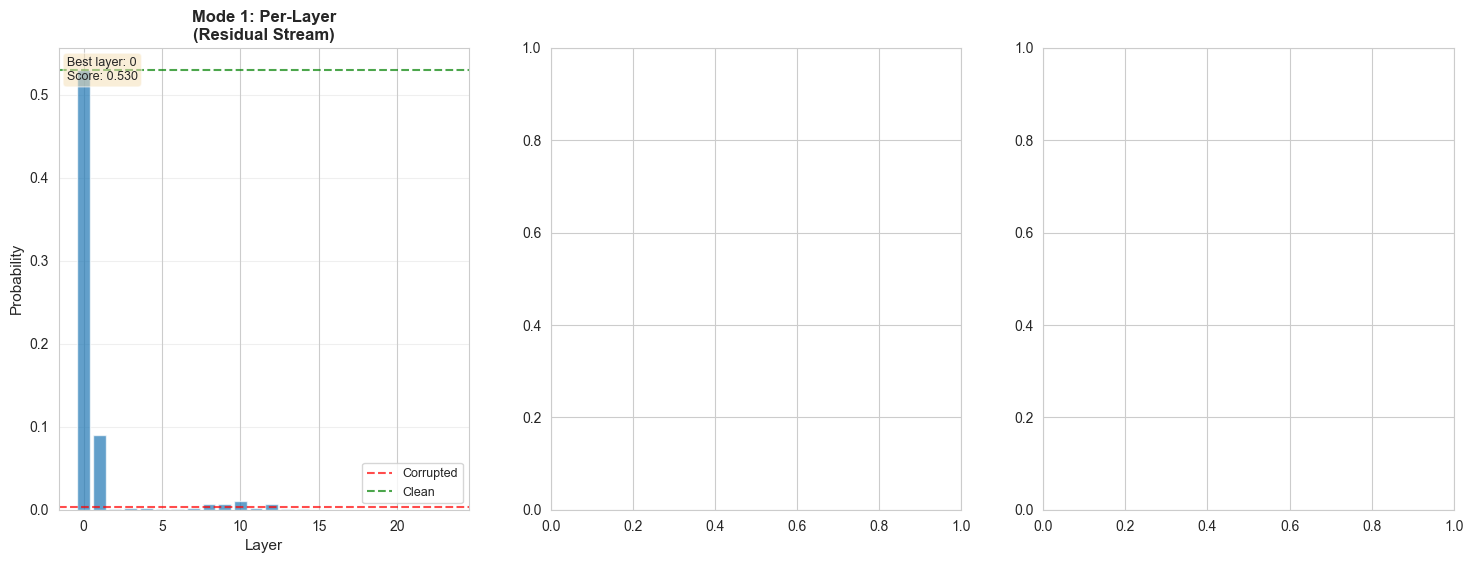

In [28]:
# Create comparison visualization
num_plots = 2 if result_per_position_ssm is None else 3
fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 6))

if num_plots == 2:
    axes = list(axes)

# Plot 1: Per-layer
ax1 = axes[0]
ax1.bar(range(len(result_per_layer['scores'])), result_per_layer['scores'], alpha=0.7)
ax1.axhline(result_per_layer['low_score'], color='red', linestyle='--', label='Corrupted', alpha=0.7)
ax1.axhline(result_per_layer['high_score'], color='green', linestyle='--', label='Clean', alpha=0.7)
ax1.set_xlabel('Layer', fontsize=11)
ax1.set_ylabel('Probability', fontsize=11)
ax1.set_title('Mode 1: Per-Layer\n(Residual Stream)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# Find best layer
best_layer = result_per_layer['scores'].argmax()
ax1.text(0.02, 0.98, f"Best layer: {best_layer}\nScore: {result_per_layer['scores'][best_layer]:.3f}",
         transform=ax1.transAxes, va='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Per-position hidden states
ax2 = axes[1]
im2 = ax2.imshow(result_per_position['scores'], aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Probability')
ax2.set_xlabel('Token Position', fontsize=11)
ax2.set_ylabel('Layer', fontsize=11)
ax2.set_title('Mode 2: Per-Position\n(Hidden States)', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(result_per_position['input_tokens'])))
ax2.set_xticklabels(result_per_position['input_tokens'], rotation=45, ha='right', fontsize=9)

# Highlight subject
subj_start, subj_end = result_per_position['subject_range']
ax2.axvline(subj_start - 0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax2.axvline(subj_end - 0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Find best (layer, pos)
best_layer_2, best_pos_2 = np.unravel_index(result_per_position['scores'].argmax(), result_per_position['scores'].shape)
ax2.plot(best_pos_2, best_layer_2, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=1.5)

# Plot 3: Per-position SSM states (if available)
if result_per_position_ssm is not None:
    ax3 = axes[2]
    im3 = ax3.imshow(result_per_position_ssm['scores'], aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='Probability')
    ax3.set_xlabel('Token Position', fontsize=11)
    ax3.set_ylabel('Layer', fontsize=11)
    ax3.set_title('Mode 3: Per-Position\n(SSM States)', fontsize=12, fontweight='bold')
    ax3.set_xticks(range(len(result_per_position_ssm['input_tokens'])))
    ax3.set_xticklabels(result_per_position_ssm['input_tokens'], rotation=45, ha='right', fontsize=9)
    
    # Highlight subject
    subj_start_3, subj_end_3 = result_per_position_ssm['subject_range']
    ax3.axvline(subj_start_3 - 0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax3.axvline(subj_end_3 - 0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Find best (layer, pos)
    best_layer_3, best_pos_3 = np.unravel_index(result_per_position_ssm['scores'].argmax(), result_per_position_ssm['scores'].shape)
    ax3.plot(best_pos_3, best_layer_3, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=1.5)

plt.suptitle(f'Causal Tracing Comparison: "{prompt}"', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"\nPrompt: \"{prompt}\"")
print(f"Target: {result_per_layer['target_token']}")
print(f"Clean probability: {result_per_layer['high_score']:.4f}")
print(f"Corrupted probability: {result_per_layer['low_score']:.4f}")
print()

print("Mode 1 (Per-Layer):")
print(f"  Best layer: {best_layer} with score {result_per_layer['scores'][best_layer]:.4f}")

print("\nMode 2 (Per-Position Hidden States):")
print(f"  Best: Layer {best_layer_2}, Position {best_pos_2}")
print(f"  Token: '{result_per_position['input_tokens'][best_pos_2]}'")
print(f"  Score: {result_per_position['scores'][best_layer_2, best_pos_2]:.4f}")

if result_per_position_ssm is not None:
    print("\nMode 3 (Per-Position SSM States):")
    print(f"  Best: Layer {best_layer_3}, Position {best_pos_3}")
    print(f"  Token: '{result_per_position_ssm['input_tokens'][best_pos_3]}'")
    print(f"  Score: {result_per_position_ssm['scores'][best_layer_3, best_pos_3]:.4f}")
else:
    print("\nMode 3 (Per-Position SSM States): Not run (set RUN_SSM_MODE = True)")

print("\n" + "="*60)

## 4b. Horizontal vs Vertical Restoration

Let's compare two different restoration strategies:
- **Horizontal Restoration**: Restore ALL time steps in a single layer (Mode 1 above)
- **Vertical Restoration**: Restore ALL layers at a single time step (NEW!)

**Intuition:**
- Horizontal: "How important is layer L for the final output?"
- Vertical: "How important is the information at position P across all layers?"

In [ ]:
# Test vertical restoration
print("\n" + "="*60)
print("VERTICAL RESTORATION")
print("="*60)
print("Restoring ALL layers at each position")
print(f"This answers: 'How important is the info at position P?'")
print()

result_vertical = calculate_hidden_flow(
    mt,
    mt.tokenizer,
    prompt=prompt,
    subject=subject,
    samples=5,  # Use 5 samples for speed
    noise_level=noise_level,
    mode="vertical",
)

print(f"✓ Complete!")
print(f"  Clean: {result_vertical['high_score']:.4f}")
print(f"  Corrupted: {result_vertical['low_score']:.4f}")
print()

# Show token-level importance
print("Position Importance:")
tokens = result_vertical['input_tokens']
scores = result_vertical['scores']
for i, (token, score) in enumerate(zip(tokens, scores)):
    bar = "#" * int(score * 50)
    print(f"  {i:2d}. {token:15s} {score:.4f} {bar}")

best_pos = scores.argmax()
print(f"\nMost important position: {best_pos} ('{tokens[best_pos]}')")

In [ ]:
# Compare horizontal (per-layer) vs vertical (all layers at position)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Horizontal restoration (per-layer)
ax1 = axes[0]
ax1.bar(range(len(result_per_layer['scores'])), result_per_layer['scores'], alpha=0.7, color='skyblue')
ax1.axhline(result_per_layer['low_score'], color='red', linestyle='--', label='Corrupted', alpha=0.7)
ax1.axhline(result_per_layer['high_score'], color='green', linestyle='--', label='Clean', alpha=0.7)
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_title('Horizontal Restoration\n(All positions in each layer)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

best_layer = result_per_layer['scores'].argmax()
ax1.text(0.02, 0.98, f"Best: Layer {best_layer}\nScore: {result_per_layer['scores'][best_layer]:.3f}",
         transform=ax1.transAxes, va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Vertical restoration (all layers at position)
ax2 = axes[1]
ax2.bar(range(len(result_vertical['scores'])), result_vertical['scores'], alpha=0.7, color='lightcoral')
ax2.axhline(result_vertical['low_score'], color='red', linestyle='--', label='Corrupted', alpha=0.7)
ax2.axhline(result_vertical['high_score'], color='green', linestyle='--', label='Clean', alpha=0.7)
ax2.set_xlabel('Token Position', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('Vertical Restoration\n(All layers at each position)', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(tokens)))
ax2.set_xticklabels(tokens, rotation=45, ha='right', fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Highlight subject range
subj_start, subj_end = result_vertical['subject_range']
ax2.axvspan(subj_start - 0.5, subj_end - 0.5, alpha=0.2, color='yellow', label='Subject')

best_pos_vertical = result_vertical['scores'].argmax()
ax2.text(0.02, 0.98, f"Best: Pos {best_pos_vertical}\nToken: '{tokens[best_pos_vertical]}'\nScore: {result_vertical['scores'][best_pos_vertical]:.3f}",
         transform=ax2.transAxes, va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Horizontal vs Vertical Restoration: "{prompt}"', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("\nHorizontal (all positions in layer):")
print(f"  - Best layer: {best_layer}")
print(f"  - Score: {result_per_layer['scores'][best_layer]:.4f}")
print(f"  - Meaning: Layer {best_layer} is most critical for output")
print(f"  - Note: Layer 0 often wins because it cleans the residual stream")
print()
print("Vertical (all layers at position):")
print(f"  - Best position: {best_pos_vertical}")
print(f"  - Token: '{tokens[best_pos_vertical]}'")
print(f"  - Score: {result_vertical['scores'][best_pos_vertical]:.4f}")
print(f"  - Meaning: Information at this position is most critical")
print(f"  - Note: Often the last token because Mamba is autoregressive")
print("\n" + "="*60)

### Key Insights: Horizontal vs Vertical

**Horizontal Restoration** (restoring all positions in a layer):
- Tests: "How important is layer L?"
- In Mamba: Layer 0 often scores highest because of residual stream architecture
- Restoring layer 0 = cleaning the entire forward path
- This works because our hooks process the full sequence after it's been computed through that layer

**Vertical Restoration** (restoring all layers at a position):
- Tests: "How important is the information at position P?"
- In Mamba: Last position often scores highest (autoregressive nature)
- But sometimes middle positions (subject tokens) can be very important
- This tells us which positions carry critical information across the entire model depth

**Why the difference?**
- Mamba's recurrent architecture means information flows both:
  - **Forward through layers** (residual stream) ← Horizontal traces this
  - **Left-to-right through time** (recurrent state) ← Vertical traces this
- Horizontal: "Which layer processes the info most critically?"
- Vertical: "Which position contains the most critical info?"

**How does horizontal restoration actually work?**
Looking at the code in [mamba_causal_trace.py:148-161](../mamba_causal_analysis/mamba_causal_trace.py#L148-L161):
- When `patch_entire_layer=True`, we restore `clean_hidden_states[:, layer_idx, :, :]`
- The `:` in position dimension means ALL positions are restored
- The hook runs AFTER the full sequence has been processed through that layer
- So we're restoring all time steps at once, which is appropriate for Mamba's fused SSM computation

## 4. Visualize All Three Modes

Compare the results from all three causal tracing modes:
1. **Per-layer**: Which layers are important? (1D plot)
2. **Per-position hidden states**: Which (layer, position) pairs matter for hidden states? (2D heatmap)
3. **Per-position SSM states**: Which (layer, position) pairs matter for SSM recurrent states? (2D heatmap)

**Key Question**: Do hidden states and SSM states show different patterns?

## 5. Detailed Layer Analysis

Let's look more closely at which layers matter for factual recall in Mamba.

In [9]:
scores = result['scores']

# Handle both 1D (per-layer) and 2D (per-position) results
if scores.ndim == 1:
    # Per-layer mode
    layer_scores = scores
else:
    # Per-position mode - average across positions
    layer_scores = scores.mean(axis=1)

# Plot layer scores
plt.figure(figsize=(12, 5))
plt.plot(layer_scores, marker='o', linewidth=2, markersize=6)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Average Restoration Effect', fontsize=12)
plt.title('Effect of Restoring Each Layer', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 5 most important layers:")
top_layers = np.argsort(layer_scores)[-5:][::-1]
for i, layer in enumerate(top_layers):
    print(f"  {i+1}. Layer {layer:2d}: {layer_scores[layer]:.4f}")

print(f"\nInterpretation for Mamba:")
print(f"  - Early layers (especially 0-5) often show high importance")
print(f"  - This is because Mamba's residual stream flows FORWARD through layers")
print(f"  - Restoring an early layer cleans the residual for all subsequent layers")
print(f"  - This is different from transformers where late layers can be more independent")

NameError: name 'result' is not defined

## 6. Comparison: What would per-position mode show?

Per-layer mode (used above) tests: "Does restoring layer L help?"
Per-position mode would test: "Does restoring layer L at position P help?"

To switch to per-position mode, set `patch_entire_layer=False` in the calculate_hidden_flow call above.

**Note:** Per-position mode is less appropriate for Mamba due to the residual stream architecture, but you can try it for comparison with transformer results from ROME.

In [ ]:
# This cell is now simpler in per-layer mode
# In per-position mode, this would analyze subject token importance

print("In per-layer mode, we trace entire layers rather than individual positions.")
print(f"\nSubject in prompt: '{subject}'")
print(f"Subject tokens: {result['input_tokens'][result['subject_range'][0]:result['subject_range'][1]+1]}")
print(f"Subject range: positions {result['subject_range'][0]} to {result['subject_range'][1]}")
print("\nFor per-position analysis, rerun with patch_entire_layer=False")

## 7. Save Results (Optional)

Save the causal tracing results for later analysis or comparison.

In [ ]:
# Uncomment to save
# output_path = f"../results/{prompt.replace(' ', '_')[:30]}_trace.npz"
# Path(output_path).parent.mkdir(parents=True, exist_ok=True)
# np.savez(
#     output_path,
#     scores=result['scores'],
#     low_score=result['low_score'],
#     high_score=result['high_score'],
#     input_tokens=result['input_tokens'],
#     subject_range=result['subject_range'],
#     target_token=result['target_token'],
#     prompt=prompt,
#     subject=subject,
# )
# print(f"Results saved to {output_path}")

## Next Steps

**Key Findings about Mamba:**
1. Early layers (especially layer 0) are often critical for factual recall
2. This is because Mamba's residual stream flows forward through layers
3. Restoring layer 0 cleans the entire computation path

**Try different prompts:**
- Change the test_cases index in cell 5
- Add your own factual prompts
- Look for patterns across different fact types

**For Phase 3:**
We'll implement per-position SSM state tracing using sequential processing to get true per-token intervention (this will be slower but more detailed).

**Comparison with Transformers (ROME paper):**
- Transformers: Middle-to-late layers often most important (10-15 for GPT-2)
- Mamba: Early layers more critical due to forward residual flow
- This suggests different information storage mechanisms!